In [1]:
import torch, os
from torch.utils.data import Dataset
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import rasterio as rio
import pandas as pd, numpy as np
os.chdir("/content")

In [4]:
with open("/content/credentials") as f:
    env_vars = f.read().split("\n")

for var in env_vars:
    key, value = var.split(" = ")
    os.environ[key] = value

storage_options = {"account_name":os.environ["ACCOUNT_NAME"],
                   "account_key":os.environ["BLOB_KEY"]}

In [5]:
labels = pd.read_csv(
    f"az://modeling-data/partitioned_feature_data_buffer500m_daytol8_cloudthr80percent_lulcndvi_masking.csv",
    storage_options=storage_options
)
not_enough_water = labels["n_water_pixels"] <= 50
labels.drop(not_enough_water[not_enough_water].index, inplace=True)

labels["raw_img_az_path"] = [f'az://{x.split(".net/")[1]}' for x in labels["raw_img_chip_href"]]
labels["water_az_path"] = [f'az://{x.split(".net/")[1]}' for x in labels["water_chip_href"]]

train_labels = labels.loc[
    labels["partition"] == "train",
    ["site_no", "sample_id", "SSC (mg/L)", "mean_viewing_azimuth",
     "mean_viewing_zenith", "mean_solar_azimuth", "mean_solar_zenith",
     "raw_img_az_path", "water_az_path", "is_brazil"]
]
validation_labels = labels.loc[
    labels["partition"] == "validate",
    ["site_no", "sample_id", "SSC (mg/L)", "mean_viewing_azimuth",
     "mean_viewing_zenith", "mean_solar_azimuth", "mean_solar_zenith",
     "raw_img_az_path", "water_az_path", "is_brazil"]
]


In [17]:
RIO_BANDS_ORDERED = {
    "aot":1, 
    "blue":2, 
    "green":3, 
    "red":4, 
    "nir":5, 
    "wvp":6,
    "rededge1":7, 
    "redege2":8, 
    "rededge3":9, 
    "rededge4":10, 
    "swir1":11, 
    "swir2":12
}

class FluviusDataset(Dataset):
    def __init__(
        self,
        labels,
        bands=["blue","green","red","nir"],
        transform=None
    ):
        self.annotations = labels
        self.transform = transform
        self.rio_band_idx = [RIO_BANDS_ORDERED.get(x) for x in bands]

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = self.annotations.iloc[index, :]["raw_img_az_path"]
        water_path = self.annotations.iloc[index, :]["water_az_path"]

        with rio.Env(
            AZURE_STORAGE_ACCOUNT=os.environ["ACCOUNT_NAME"],
            AZURE_STORAGE_ACCESS_KEY=os.environ["BLOB_KEY"]
        ):
            with rio.open(img_path) as ds:
                spect_img = (ds.read(
                    tuple(
                        self.rio_band_idx
                    )
                ).clip(0, 15000) / (15000)).astype(np.float32)
            with rio.open(water_path) as ds:
                water = ds.read().astype(np.float32)
        img = np.moveaxis(
            (np.concatenate([spect_img, water], axis=0) - 0.5) * 2,
            0, -1)

        y_label = torch.tensor(np.log(self.annotations.iloc[index, :]["SSC (mg/L)"]).astype(np.float32))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [18]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), # Converts ndarray to tensor
        transforms.Resize((96,96))
    ]
)

In [19]:
## HyperParameters
train_batch_size = 64
val_batch_size = 8
learning_rate = 0.001
epochs = 100


## Load DataSets
train = FluviusDataset(train_labels, transform=transform)
validation = FluviusDataset(validation_labels, transform=transform)

## Set up data loaders
train_loader = DataLoader(
    train,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=0
)
val_loader = DataLoader(
    validation,
    batch_size=val_batch_size,
    shuffle=False,
    num_workers=0
)

val_loader_all = DataLoader(
    validation,
    batch_size=1,
    shuffle=False,
    num_workers=0
)


In [20]:
## Specify the model
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=5,
            out_channels=8,
            kernel_size=3,
            padding=1
        )
        self.avgpool1 = nn.AvgPool2d(kernel_size=16, stride=16)
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=2,
            kernel_size=3
        )
        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(288, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.avgpool1(F.relu(self.conv1(x))) # Convolve, activate, pool #1
        #x = self.avgpool2(F.relu(self.conv2(x))) # Convolve, activate, pool #2
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x)) # Fully connected layers
        x = self.fc2(x).squeeze()
        return x

In [21]:
## Train the model!
model = CNN(len(train.rio_band_idx))

import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics288
        running_loss += loss.item()
    
    # Validation loss:
    with torch.no_grad():
        val_loss = 0
        model.eval()
        for i, data in enumerate(val_loader_all):
            inputs, labels = data
            y_val_pred = model(inputs)
            val_loss = criterion(y_val_pred, labels)
            val_loss += val_loss.item()
    
    print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {running_loss/len(train_loader):.3f} | Val Loss: {val_loss:.3f}")


print('Finished Training')

In [84]:
val_pred_list = []
with torch.no_grad():
        model.eval()
        for img, _ in val_loader_all:
                y_pred = model(img)
                val_pred_list.append(y_pred.tolist())


In [85]:
observed = [validation.__getitem__(x)[1].tolist() for x in range(validation.__len__())]

In [86]:
from matplotlib import pyplot as plt

def plot_obs_predict(obs_pred, title, savefig=False, outfn=""):
    plt.figure(figsize=(8,8))
    plt.plot(list(range(0,8)),list(range(0,8)), color="black", label="One-to-one 1 line")
    plt.scatter(obs_pred.iloc[:,0], obs_pred.iloc[:,1])
    plt.axvline(x=np.mean(obs_pred.iloc[:,1]), color="black")
    plt.xlabel("ln(SSC) Predicted")
    plt.ylabel("ln(SSC) Observed")
    plt.title(title)
    plt.legend()
    if savefig:
        plt.savefig(
            outfn,
            bbox_inches="tight",
            facecolor="#FFFFFF",
            dpi=150
        )

obs_pred = pd.DataFrame({
    "predicted": val_pred_list,
    "observed": observed
})

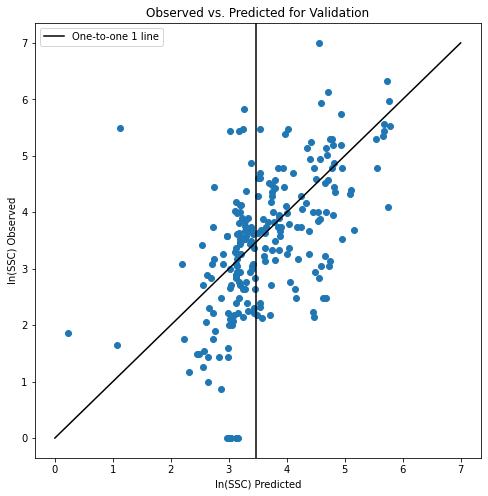

In [87]:
plot_obs_predict(obs_pred, "Observed vs. Predicted for Validation")